In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.distributions import Categorical
import matplotlib.pyplot as plt
import matplotlib
import pandas as pd
import numpy as np
import pickle
from torch.utils.data import Dataset, TensorDataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler, RobustScaler, MaxAbsScaler
from scipy import stats
from tqdm import tqdm
# from skbio.stats.composition import clr
use_cuda = torch.cuda.is_available()
device = torch.device('cuda:0' if use_cuda else 'cpu')
print(device)

from utils import *

import matplotlib as mpl
mpl.rcParams['font.family'] = 'Arial'
mpl.rcParams['font.size'] = 14

from sklearn.metrics import mean_squared_error
from scipy.stats import pearsonr

cuda:0


In [2]:
def load_model_and_data(p_model, p_data):
    annotations = torch.load(p_model)["annotations"]
    features = torch.load(p_data)["features"]
    labels = torch.load(p_data)["labels"]
    spc_names, train_indices, test_indices = annotations["spcs"], annotations["train_idx"], annotations["test_idx"]
    
    X_train = features[train_indices]
    X_test = features[test_indices]
    y_train = labels[train_indices]
    y_test = labels[test_indices]
    
    ## clr transformation for outputs
    zero_thr = 1e-8
    gmean_train = (np.exp(np.nansum(np.log(y_train[y_train > 0]+zero_thr)) / np.size(y_train)))
    y_train_clr = np.log((y_train+zero_thr)/gmean_train)
    y_test_clr = np.log((y_test+zero_thr)/gmean_train)

    ## rescale the data
    scaler = preprocessing.MaxAbsScaler().fit(y_train_clr)
    # scaler = preprocessing.RobustScaler().fit(y_train_clr)
    y_train_scaled = scaler.transform(y_train_clr)
    y_test_scaled = scaler.transform(y_test_clr)

    ## transform to tensors
    X_train_scaled=torch.from_numpy(X_train).float()
    y_train_scaled=torch.from_numpy(y_train_scaled).float()
    X_test_scaled=torch.from_numpy(X_test).float()
    y_test_scaled=torch.from_numpy(y_test_scaled).float()
    
    input_dim = len(spc_names)
    # downsize for model for synthetic_v1
    hidden_dim = 2048
    latent_dim = 25
    model = VAE_2(input_dim, latent_dim, hidden_dim).to(device)
    model.load_state_dict(torch.load(p_model)["model"])
    
    return X_train_scaled, X_test_scaled, y_train_scaled, y_test_scaled, annotations, model

### Evaluate reconstruction

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


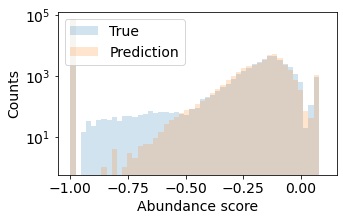

(108000,) 108000


In [3]:
p_model = "../models/synthetic_v1_trained_AE.pt"
p_data = "../data/synthetic_v1_filtered.pt"
X_train_scaled, X_test_scaled, y_train_scaled, y_test_scaled, annotations, model = load_model_and_data(p_model, p_data)

class CustomDataset(Dataset):
    def __init__(self, features, labels, device=None):
        self.labels = labels
        self.features = features
    def __len__(self):
        return len(self.labels)
    def __getitem__(self, idx):
        label = self.labels[idx]
        data = self.features[idx]
        return {"Features": data, "Labels": label}
Train = CustomDataset(X_train_scaled, y_train_scaled)
Test = CustomDataset(X_test_scaled, y_test_scaled)
kwargs = {'num_workers': 4, 'pin_memory': True} if use_cuda else {}
train_DS = DataLoader(Train, batch_size=100, shuffle=True, drop_last=False, **kwargs)
test_DS = DataLoader(Test, batch_size=100, shuffle=True, drop_last=False, **kwargs)

# compare initial and reconstructed features
plt.figure(figsize=(5, 3))
plt.hist(y_test_scaled.numpy().flatten(), bins=np.linspace(-1, 0.1, 50), alpha=0.2, label="True")
all_recon = []
weights = [1.0, 1.0, 0.0]
for batch in test_DS:
    b, nb, loss, recon_loss, bce_loss, kl_loss = compute_loss_2(model, batch['Features'].to(device), batch['Labels'].to(device), weights)
    recon_x = (b>0.5).float()*nb + (b<0.5).float()*(-1)
    recon_x = recon_x.detach().cpu().numpy().flatten()
    all_recon.extend(list(recon_x))
plt.hist(all_recon, bins=np.linspace(-1, 0.1, 50), alpha=0.2, label="Prediction")
plt.yscale("log")
plt.legend()
plt.xlabel("Abundance score")
plt.ylabel("Counts")
handle = p_data.split("/")[-1][:-3]
plt.savefig(f"../figures/eval_distribution_{handle}.pdf", bbox_inches="tight")
plt.show()

print(y_test_scaled.numpy().flatten().shape, len(all_recon))

20it [00:00, 189.88it/s]


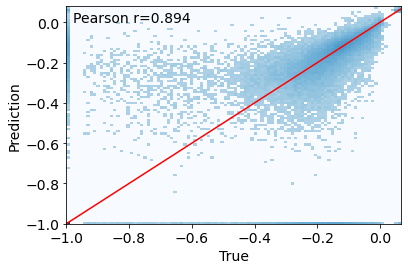

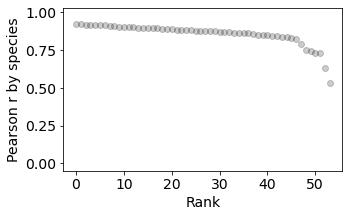

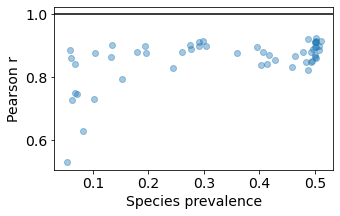

In [4]:
# check the reconstruction values
true_x_list = []
recon_x_list = []
n_batch_use = 1e3

for (idx, batch) in tqdm(enumerate(test_DS)):
    true_x = batch['Labels'].detach().numpy()
    b, nb, loss, recon_loss, bce_loss, kl_loss = compute_loss_2(model, batch['Features'].to(device), batch['Labels'].to(device), weights)
    recon_x = (b>0.5).float()*nb + (b<0.5).float()*(-1)
    recon_x = recon_x.detach().cpu().numpy()
    true_x_list.append(true_x)
    recon_x_list.append(recon_x)
    if(idx>=n_batch_use):
        break
        
true_x_list = np.vstack(true_x_list)
recon_x_list = np.vstack(recon_x_list)
plt.figure(figsize=(6, 4))
plt.hist2d(x=true_x_list.flatten(), y=recon_x_list.flatten(), norm=matplotlib.colors.PowerNorm(1/10), cmap='Blues', bins=100)
plt.plot([-1.0, 0.2], [-1.0, 0.2], color="r")
plt.xlabel("True")
plt.ylabel("Prediction")
r, _ = stats.pearsonr(true_x_list.flatten(), recon_x_list.flatten())
mse_ae = mean_squared_error(true_x_list.flatten(), recon_x_list.flatten(), squared=False)
plt.gca()
# plt.text(0.02, 0.98, f'MSE loss={mse_ae:.3f}', transform=plt.gca().transAxes, va='top')
plt.text(0.02, 0.98, f'Pearson r={r:.3f}', transform=plt.gca().transAxes, va='top')

handle = p_data.split("/")[-1][:-3]
plt.savefig(f"../figures/eval_fit_{handle}.pdf", bbox_inches="tight")
plt.show()

# Pearson r by species
coeffs = [ stats.pearsonr(true_x_list[:, i], recon_x_list[:, i]) for i in range(true_x_list.shape[1]) ]
coeffs_sorted = sorted(enumerate(coeffs), key=lambda x: x[1], reverse=True)
plt.figure(figsize=(5, 3))
plt.scatter(range(len(coeffs)), [val[0] for (idx, val) in coeffs_sorted], color="k", alpha=0.2)
plt.xlabel("Rank")
plt.ylabel("Pearson r by species")
plt.ylim(-0.05, 1.03)
handle = p_data.split("/")[-1][:-3]
plt.savefig(f"../figures/eval_pearson_by_spc_{handle}.pdf", bbox_inches="tight")
plt.show()
    
# predictibility vs prevalence
X_all = torch.vstack([X_train_scaled, X_test_scaled]).numpy()
plt.figure(figsize=(5, 3))
plt.scatter([np.sum(X_all[:, i]>0)/X_all.shape[0] for i in range(X_all.shape[1])], \
             [i[0] for i in coeffs], alpha=0.4)
plt.xlabel("Species prevalence")
plt.ylabel("Pearson r")
# plt.ylim(-0.05, 1.03)
plt.axhline(1.0, color="k")
handle = p_data.split("/")[-1][:-3]
plt.savefig(f"../figures/eval_pearson_vs_prev_{handle}.pdf", bbox_inches="tight")
plt.show()

# top x best predicted species
# spc_names = annotations["spcs"]
# for i in range(20):
#     print(coeffs_sorted[i][1][0], spc_names[coeffs_sorted[i][0]])

### Compare with simple traditional methods
We might not put plots in the finalized version. We should generate synthetic datasets across some different bio parameters (such as the growth rate distribution width or whatever about the resource influx) and show that AE is better than RF/EN in all/most of these cases

In [7]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import ElasticNet
from sklearn.multioutput import MultiOutputRegressor

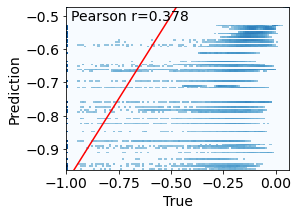

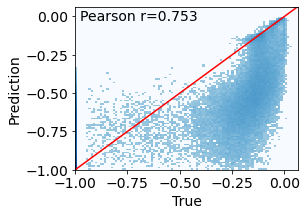

In [12]:
# RF
rf = RandomForestRegressor(n_estimators=100, max_depth=None, random_state=42, n_jobs=-1)
rf.fit(X_train_scaled.numpy(), y_train_scaled.numpy())
y_pred_rf = rf.predict(X_test_scaled.numpy())
ccrf, p_rf = pearsonr(y_test_scaled.numpy().flatten(), y_pred_rf.flatten())
mse_rf = mean_squared_error(y_test_scaled.numpy(), y_pred_rf, squared=False)

# Elastic Net
en = MultiOutputRegressor(ElasticNet(alpha=1.0, l1_ratio=0.5, max_iter=10000))
en.fit(X_train_scaled.numpy(), y_train_scaled.numpy())
y_pred_en = en.predict(X_test_scaled.numpy())
ccen, p_en = pearsonr(y_test_scaled.numpy().flatten(), y_pred_en.flatten())
mse_en = mean_squared_error(y_test_scaled.numpy(), y_pred_en, squared=False)

true_x_list = []
recon_x_list = []
n_batch_use = 100

# Elastic net
true_x_list = y_test_scaled.numpy()
recon_x_list = y_pred_en
plt.figure(figsize=(4, 3))
plt.hist2d(x=true_x_list.flatten(), y=recon_x_list.flatten(), norm=matplotlib.colors.PowerNorm(1/10), cmap='Blues', bins=100)
plt.plot([-1.0, 0.2], [-1.0, 0.2], color="r")
plt.xlabel("True")
plt.xlabel("True")
plt.ylabel("Prediction")
plt.gca()
# plt.text(0.02, 0.98, f'MSE loss={mse_en:.3f}', transform=plt.gca().transAxes, va='top')
plt.text(0.02, 0.98, f'Pearson r={ccen:.3f}', transform=plt.gca().transAxes, va='top')
plt.show()


# RF
true_x_list = y_test_scaled.numpy()
recon_x_list = y_pred_rf
plt.figure(figsize=(4, 3))
plt.hist2d(x=true_x_list.flatten(), y=recon_x_list.flatten(), norm=matplotlib.colors.PowerNorm(1/10), cmap='Blues', bins=100)
plt.plot([-1.0, 0.2], [-1.0, 0.2], color="r")
plt.xlabel("True")
plt.xlabel("True")
plt.ylabel("Prediction")
r, _ = stats.pearsonr(true_x_list.flatten(), recon_x_list.flatten())
plt.gca()
# plt.text(0.02, 0.98, f'MSE loss={mse_rf:.3f}', transform=plt.gca().transAxes, va='top')
plt.text(0.02, 0.98, f'Pearson r={ccrf:.3f}', transform=plt.gca().transAxes, va='top')
plt.show()

### Keystoneness, Invasiveness and interactions

In [5]:
'''
Flip a species's binary in the input and reconstruct the abundances. 
Compare it with the re-normalized abundance of other species. 
'''
# get parameter of data preprocessing so that we can transform back to relative abundance afterwards
def get_preprocess(p_data, p_model):
    _, _, _, _, annotations, model = load_model_and_data(p_model, p_data)
    train_indices = annotations["train_idx"]
    test_indices = annotations["test_idx"]
    
    features = torch.load(p_data)["features"]
    labels = torch.load(p_data)["labels"]
    spc_names = torch.load(p_data)["names"]
    
    original_indices = np.arange(len(features))
    train_indices, test_indices = train_test_split(
        original_indices,
        test_size=0.2,
        random_state=42,
    )
    X_train = features[train_indices]
    X_test = features[test_indices]
    y_train = labels[train_indices]
    y_test = labels[test_indices]
#     print(y_test)

    ## clr transformation for outputs
    zero_thr = 1e-8
    gmean_train = (np.exp(np.nansum(np.log(y_train[y_train > 0]+zero_thr)) / np.size(y_train)))
    y_train_clr = np.log((y_train+zero_thr)/gmean_train)
    y_test_clr = np.log((y_test+zero_thr)/gmean_train)

    ## rescale the data
    scaler = preprocessing.MaxAbsScaler().fit(y_train_clr)
    
    return gmean_train, scaler

def preproc_inverse(abundance_scores, scaler, zero_thr=1e-8):
    before_scale = scaler.inverse_transform(abundance_scores)
#     before_scale = abundance_scores
    exp_vals = np.exp(before_scale)
    return exp_vals / (np.sum(exp_vals, axis=1, keepdims=True)+zero_thr)

In [46]:
from collections import defaultdict
from scipy.spatial.distance import braycurtis

p_model = "../models/synthetic_v1_trained_AE.pt"
p_data = "../data/synthetic_v1_filtered.pt"

X_train_scaled, X_test_scaled, y_train_scaled, y_test_scaled, annotations, model = load_model_and_data(p_model, p_data)
class CustomDataset(Dataset):
    def __init__(self, features, labels, device=None):
        self.labels = labels
        self.features = features
    def __len__(self):
        return len(self.labels)
    def __getitem__(self, idx):
        label = self.labels[idx]
        data = self.features[idx]
        return {"Features": data, "Labels": label}
Train = CustomDataset(X_train_scaled, y_train_scaled)
Test = CustomDataset(X_test_scaled, y_test_scaled)
kwargs = {'num_workers': 4, 'pin_memory': True} if use_cuda else {}
train_DS = DataLoader(Train, batch_size=100, shuffle=True, drop_last=False, **kwargs)
test_DS = DataLoader(Test, batch_size=100, shuffle=True, drop_last=False, **kwargs)

gmean, scaler = get_preprocess(p_data, p_model)
zero_thr = 1e-8
model.eval()


# Keystoneness
num_species = X_test_scaled.shape[1]
keystone_distributions = defaultdict(list)
key_interactions = np.empty((num_species, num_species), dtype=object)
for i in range(num_species):
    for j in range(num_species):
        key_interactions[i, j] = []

batches_use = 100

for bdx, batch in tqdm(enumerate(train_DS)):
    x = batch['Features'].to(device)
    with torch.no_grad():
        # debug this
        b, nb, _, _ = model(x)
        recon_orig = (b>0.5).float()*nb + (b<0.5).float()*(-1)

    for i in range(x.shape[0]):
        x_i = x[i].clone()
        recon_i_scaled = recon_orig[i].cpu().numpy()
        if x_i.sum() == 0:
            continue  # skip samples with no microbes present
            
        present_indices = torch.nonzero(x_i).flatten()
        
        # get the "unperturbed" abundances for all possible 1->0 flips of this sample
        recon_i_scaled_all = np.tile(recon_i_scaled, (len(present_indices), 1))
        b_relab_all = np.tile(b[i].cpu().numpy(), (len(present_indices), 1))
        orig_relab_all = preproc_inverse(recon_i_scaled_all, scaler)
        orig_relab_all = (b_relab_all>0.5)*orig_relab_all
        renorm_orig_relab_all = orig_relab_all.copy()
        for idx, j in enumerate(present_indices):
            renorm_orig_relab_all[idx, j.item()] = 0.0
        renorm_orig_relab_all /= np.sum(renorm_orig_relab_all, axis=1, keepdims=True) 
        # get the "perturbed" abundances for all possible 1->0 flips of this sample
        x_pert = torch.tile(x_i, (len(present_indices), 1))
        for idx, j in enumerate(present_indices):
            x_pert[idx, j.item()] = 0
        with torch.no_grad():
            b_pert, nb_pert, *_ = model(x_pert)
            recon_perturbed_scaled = (b_pert>0.5).float()*nb_pert + (b_pert<0.5).float()*(-1)
        perturbed_relab_all = preproc_inverse(recon_perturbed_scaled.cpu().numpy(), scaler)
        perturbed_relab_all = (b_pert.cpu().numpy()>0.5)*perturbed_relab_all
        
        # get the bray-curtis distances
        for idx, j in enumerate(present_indices):
            j = j.item()
            dist = braycurtis(renorm_orig_relab_all[idx], perturbed_relab_all[idx])
            keystone_distributions[j].append(dist)
            
        # get the interactions
        difference = np.log10( (perturbed_relab_all+zero_thr)/(renorm_orig_relab_all+zero_thr) )
        for idx, j in enumerate(present_indices):
            j = j.item()
            for jdx in range(num_species):
                if(renorm_orig_relab_all[idx, jdx]>0):
                    key_interactions[j, jdx].append(difference[idx, jdx])
            
    bdx+=1
    if(bdx>=batches_use): break
            
# Compute average keystone score per species
keystone_scores = {
    i: np.mean(dists) for i, dists in keystone_distributions.items()
}

80it [01:08,  1.16it/s]


findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


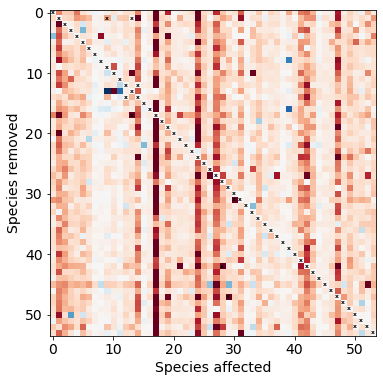

In [47]:
heatmap = np.zeros([num_species, num_species])
xxs, xys = [], []
for i in range(num_species):
    for j in range(num_species):
        if(len(key_interactions[i, j])>0):
            heatmap[i, j] = np.mean(key_interactions[i, j])
        else:
            xxs.append(i)
            xys.append(j)

fig, ax = plt.subplots(figsize=(6, 6))
ax.imshow(heatmap, cmap="RdBu", vmin=-1, vmax=1,
            aspect='equal') 
for x, y in zip(xxs, xys):
    ax.text(x, y, 'x',
            color='black',
            ha='center',
            va='center',
            fontsize=6, 
            weight='bold')
ax.set_xlabel("Species affected")
ax.set_ylabel("Species removed")
handle = p_data.split("/")[-1][:-3]
plt.savefig(f"../figures/keystoneness_i_to_j_{handle}.pdf", bbox_inches="tight")
plt.show()

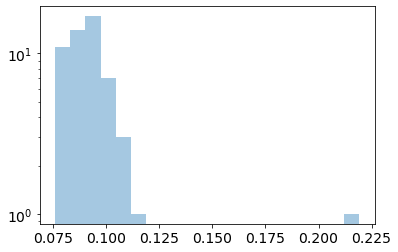

In [48]:
plt.hist(keystone_scores.values(), bins=20, alpha=0.4)
plt.yscale('log')

In [51]:
heatmap

array([[ 0.        , -0.48944634, -0.24625051, ...,  0.06570321,
        -0.34493887, -0.10099408],
       [-0.18384942,  0.        , -0.19978496, ..., -0.19347057,
        -0.11709234, -0.43696707],
       [-0.08643516, -1.0005542 ,  0.        , ..., -0.19893163,
        -0.46727264, -0.22492009],
       ...,
       [ 0.05146543, -0.40566549, -0.28634608, ...,  0.        ,
        -0.01038685, -0.16001888],
       [-0.26539588, -0.15595886, -0.4652617 , ..., -0.15832567,
         0.        , -0.10997367],
       [-0.1646347 , -0.58929259, -0.35021225, ...,  0.25454858,
        -0.11111523,  0.        ]])

In [176]:
# Invasiveness
num_species = X_test_scaled.shape[1]
invader_distributions = defaultdict(list)
inv_interactions = np.empty((num_species, num_species), dtype=object)
for i in range(num_species):
    for j in range(num_species):
        inv_interactions[i, j] = []

batches_use = 1

for bdx, batch in tqdm(enumerate(train_DS)):
    x = batch['Features'].to(device)
    with torch.no_grad():
        b, nb, *_ = model(x)
        recon_orig = (b>0.5).float()*nb + (b<0.5).float()*(-1)

    for i in range(x.shape[0])[:1]:
        x_i = x[i].clone()
        recon_i_scaled = recon_orig[i].cpu().numpy()
        if x_i.sum() == x_i.shape[0]:
            continue  # skip if all species are already present
            
        absent_indices = torch.nonzero(x_i == 0).flatten()
        
        # before the 0->1 flip
        recon_i_scaled_all = np.tile(recon_i_scaled, (len(absent_indices), 1))
        orig_relab_all = preproc_inverse(recon_i_scaled_all, scaler)
        renorm_orig_relab_all = orig_relab_all.copy()
        # get the "perturbed" abundances for all possible 0->1 flips of this sample
        x_pert = torch.tile(x_i, (len(absent_indices), 1))
        for idx, j in enumerate(absent_indices):
            x_pert[idx, j.item()] = 1
        with torch.no_grad():
            _, recon_perturbed_scaled, *_ = model(x_pert)
        perturbed_relab_all = preproc_inverse(recon_perturbed_scaled.cpu().numpy(), scaler)
        
        # get the bray-curtis distances
        for idx, j in enumerate(absent_indices):
            j = j.item()
            dist = braycurtis(renorm_orig_relab_all[idx], perturbed_relab_all[idx])
            invader_distributions[j].append(dist)
            
        # get the interactions
        difference = np.log10( (perturbed_relab_all+zero_thr)/(renorm_orig_relab_all+zero_thr) )
        for idx, j in enumerate(absent_indices):
            j = j.item()
            for jdx in range(num_species):
                if(renorm_orig_relab_all[idx, jdx]==0):
                    inv_interactions[j, jdx].append(difference[idx, jdx])
            
    bdx+=1
    if(bdx>=batches_use): break
            
# Compute average keystone score per species
invader_scores = {
    i: np.mean(dists) for i, dists in invader_distributions.items()
}

0it [00:00, ?it/s]


In [180]:
recon_orig

tensor([[-0.3760, -0.2604, -0.1566,  ..., -0.4530, -0.1768, -0.1885],
        [-0.2712, -0.3104, -0.0805,  ..., -0.1989, -0.1924, -0.1093],
        [-0.3613, -0.3481, -0.0752,  ..., -0.2071, -0.1301, -0.1052],
        ...,
        [-0.1239, -0.3287, -0.0485,  ..., -0.1579, -0.1619, -0.2196],
        [-0.1942, -0.2157, -0.1419,  ..., -0.1507, -0.1105, -0.1495],
        [-0.1997, -0.2705, -0.1424,  ..., -0.1289, -0.1727, -0.1125]],
       device='cuda:0')

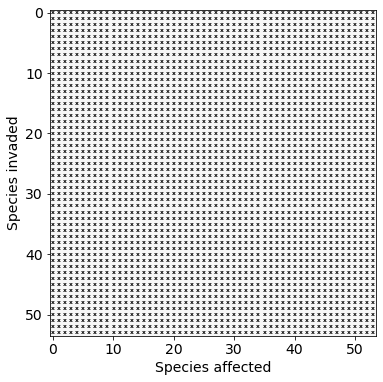

In [175]:
heatmap = np.zeros([num_species, num_species])
xxs, xys = [], []
for i in range(num_species):
    for j in range(num_species):
        if(len(inv_interactions[i, j])>0):
            heatmap[i, j] = np.mean(inv_interactions[i, j])
        else:
            xxs.append(i)
            xys.append(j)

fig, ax = plt.subplots(figsize=(6, 6))
ax.imshow(heatmap, cmap="RdBu", vmin=-1, vmax=1,
            aspect='equal') 
for x, y in zip(xxs, xys):
    ax.text(x, y, 'x',
            color='black',
            ha='center',
            va='center',
            fontsize=6, 
            weight='bold')
ax.set_xlabel("Species affected")
ax.set_ylabel("Species invaded")
handle = p_data.split("/")[-1][:-3]
plt.savefig(f"../figures/invadability_i_to_j_{handle}.pdf", bbox_inches="tight")
plt.show()

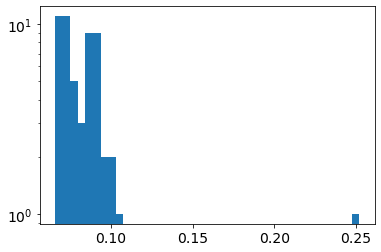

In [122]:
plt.hist(invader_scores.values(), bins=40)
plt.yscale('log')

In [121]:
invader_scores

{0: 0.09091321108893022,
 1: 0.07322182611346774,
 2: 0.06844276049996821,
 3: 0.09877761231062288,
 4: 0.07134226941722889,
 5: 0.10061690714320207,
 6: 0.08169781393143237,
 7: 0.06986743276307524,
 8: 0.09351274906073385,
 9: 0.0847117700675156,
 10: 0.07885252481329112,
 11: 0.07618099687121996,
 12: 0.09165138013398834,
 17: 0.06572476888587751,
 18: 0.07188917922277852,
 19: 0.07417761742062692,
 21: 0.07294756777227882,
 22: 0.08477931090473953,
 24: 0.06917779110388413,
 25: 0.07094136504167868,
 26: 0.08800898086736816,
 27: 0.07807668786958856,
 28: 0.07305101882166015,
 29: 0.08894155465493815,
 30: 0.08400997924853569,
 31: 0.0666173467025122,
 33: 0.06903523182833286,
 35: 0.09664249347525915,
 37: 0.09077940444262485,
 39: 0.0959775464350768,
 41: 0.0693350331771807,
 42: 0.06941434303325698,
 44: 0.0726366474560644,
 46: 0.07845107860462186,
 47: 0.06893094275324581,
 49: 0.07244925415725029,
 50: 0.09205383926183701,
 52: 0.08095196971690687,
 53: 0.08802146349573106,
 